# Quick Comparison of shallow non convolutional GANs and Convolutional GANs


Based on [Hands on Machine Learning with Scikit-learn, Tensorflow and Keras](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
%tensorflow_version 2.x
from tensorflow import keras
from tensorflow import data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Use the fashion_mnist dataset for simplicity

In [ ]:
((X_train, y_train), (X_test, y_test)) = keras.datasets.fashion_mnist.load_data()
# Only using X_train
X_train = X_train / 255

In [ ]:
def prepare_dataset(X):
    batch_size = 32
    X = tf.cast(X, tf.float32)
    dataset = data.Dataset.from_tensor_slices(X).shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(2)
    return dataset

In [ ]:
dataset = prepare_dataset(X_train)
it = iter(dataset)
batch  = next(it)

In [ ]:
def plot_batch(batch):
    out = []
    batch_size = len(batch)
    cols = batch_size//4
    for i in range(cols):
        out.append(np.vstack(batch[i*4:i*4+4]))
    out = np.hstack(out)
    fig, ax = plt.subplots(figsize=(8, 16))
    ax.imshow(out,cmap='gray')
    ax.axis('off')


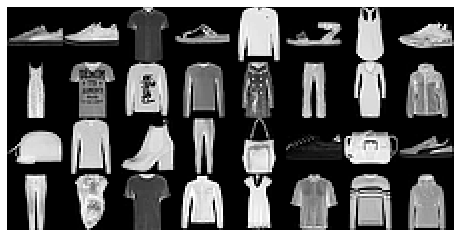

In [ ]:
plot_batch(batch)

## Shallow non convolutional GAN

Training loop for the gan, in two steps:
1. train the discriminator with fake images from the generator and real images from the dataset
2. train the generator by forcing all labels to be 'real' and freezing the weights of the discriminator

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs)):
        for X_batch in dataset:

            # train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # train generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

In [ ]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape((28, 28))
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_21 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_22 (Dense)             (None, 784)               118384    
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28)            0         
Total params: 136,634
Trainable params: 136,634
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Takes c. 20s per epoch on colab with gpu
train_gan(gan, dataset, 32, codings_size, n_epochs=2)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:21<00:21, 21.94s/it]

100%|██████████| 2/2 [00:43<00:00, 21.86s/it]



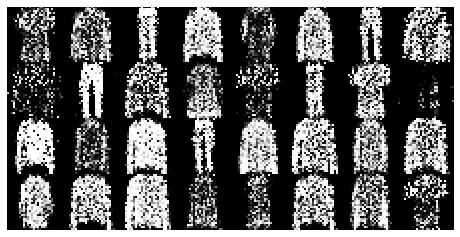

In [ ]:
noise = tf.random.normal(shape=[32, codings_size])
generated_images = generator(noise)
plot_batch(generated_images)

## Deeper GAN with convolutional layers

In [ ]:
# Rescale training set to match network
X_train_r = X_train.reshape(-1, 28, 28, 1) * 2. -1.
cgan_dataset = prepare_dataset(X_train_r)

In [ ]:
codings_size = 100

cgan_generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
],name='generator')

cgan_discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
],name='discriminator')

cgan = keras.models.Sequential([cgan_generator, cgan_discriminator])

cgan_discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
cgan_discriminator.trainable = False
cgan.compile(loss='binary_crossentropy', optimizer='rmsprop')

What the generator produces before training - random noise:

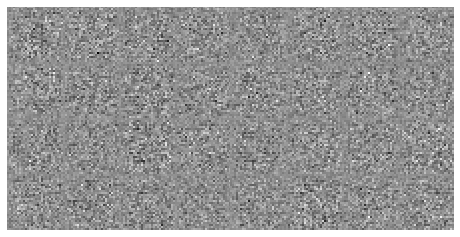

In [ ]:
noise = tf.random.normal(shape=[32, codings_size])
generated_images = cgan_generator(noise)
generated_images = tf.reshape(generated_images, (32, 28, 28))
plot_batch(generated_images)

In [ ]:
# Takes c. 1 minute per epoch on colab with gpu
train_gan(cgan, cgan_dataset, 32, 100, 2)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [01:01<01:01, 61.94s/it]

100%|██████████| 2/2 [02:02<00:00, 61.45s/it]



What the generator produces after training

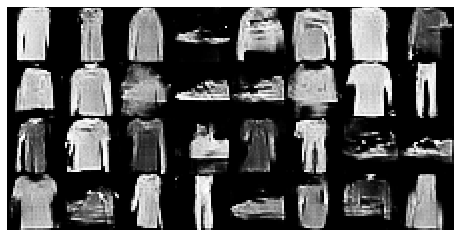

In [ ]:
noise = tf.random.normal(shape=[32, codings_size])
generated_images = cgan_generator(noise)
generated_images = tf.reshape(generated_images, (32, 28, 28))
# Undo the transformaton on the dataset
generated_images = (generated_images+1)/2
plot_batch(generated_images)

This generator looks a lot better than the previous one that doesn't use the convolutional layers - compared to the originals its actually quite convincing, although obviouslly not perfect

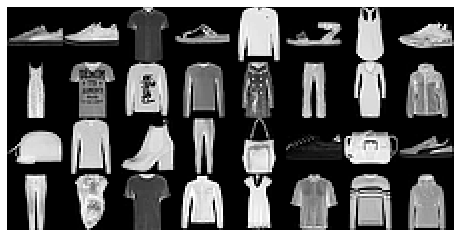

In [ ]:
plot_batch(batch)

In [ ]:
# Saving the models to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dir = 'drive/My Drive/GANs/models'
cgan_path = dir+'/cgan.h5'
gen_path = dir+'/cgan_gen.h5'
dis_path = dir+'/cgan_dis.h5'

cgan.save(cgan_path)
cgan_generator.save(gen_path)
cgan_discriminator.save(dis_path)